In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import os;
path="."
os.chdir(path)
os.getcwd()

import csv

from IPython.display import clear_output
from livelossplot import PlotLossesKeras
from time import time
from keras.callbacks import TensorBoard

from keras.utils.vis_utils import plot_model
from keras.models import load_model

from ann_visualizer.visualize import ann_viz;
from keras.models import model_from_json

from keras_sequential_ascii import keras2ascii
from livelossplot import PlotLossesKeras

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

from keras.optimizers import SGD, Adam, RMSprop, Adagrad
import pickle

# Variables
dataset=np.loadtxt("../data/datarelax.txt")

/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lk/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

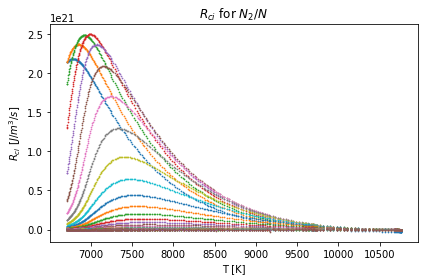

In [2]:
# ... only for plotting
dataset=np.loadtxt("../data/datarelax.txt")
x=dataset[:,0:1]  # Temperatures
y=dataset[:,1:50]  # Rci (relaxation source terms)

for i in range (2,48):
    plt.scatter(dataset[:,0:1], dataset[:,i], s=0.5, label=i)
    
plt.title('$R_{ci}$ for $N_2/N$')
plt.xlabel('T [K]')
plt.ylabel('$R_{ci}$ $[J/m^3/s]$')
#plt.legend()
plt.tight_layout()
plt.savefig("relaxation_source_terms.pdf")
plt.show()

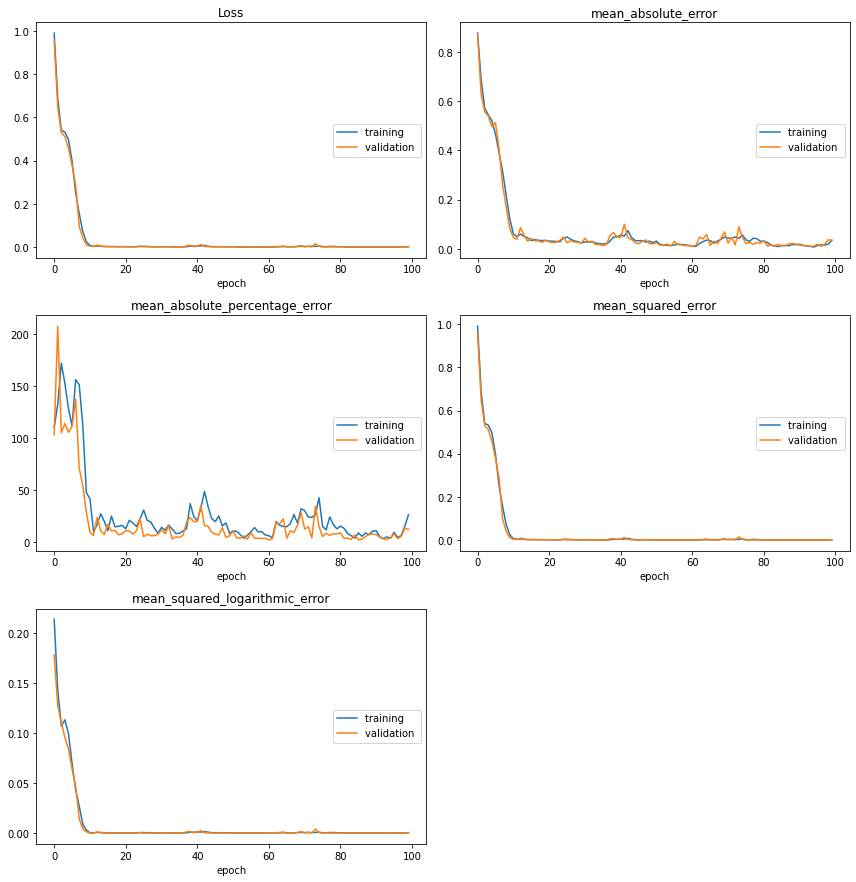

Loss
	training         	 (min:    0.000, max:    0.991, cur:    0.002)
	validation       	 (min:    0.000, max:    0.957, cur:    0.002)
mean_absolute_error
	training         	 (min:    0.007, max:    0.876, cur:    0.035)
	validation       	 (min:    0.010, max:    0.870, cur:    0.034)
mean_absolute_percentage_error
	training         	 (min:    3.554, max:  172.417, cur:   26.573)
	validation       	 (min:    2.097, max:  207.892, cur:   12.352)
mean_squared_error
	training         	 (min:    0.000, max:    0.991, cur:    0.002)
	validation       	 (min:    0.000, max:    0.957, cur:    0.002)
mean_squared_logarithmic_error
	training         	 (min:    0.000, max:    0.214, cur:    0.000)
	validation       	 (min:    0.000, max:    0.178, cur:    0.000)
205/205 - 2s - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 26.5727 - mean_squared_logarithmic_error: 4.9224e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_me

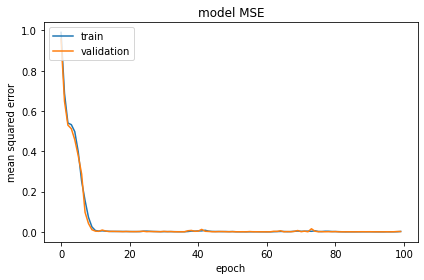

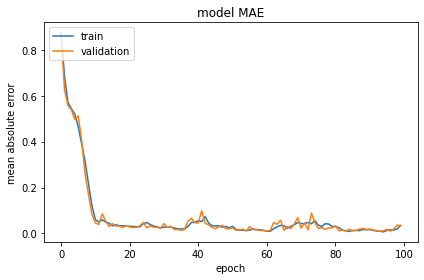

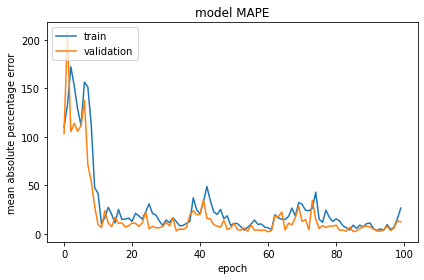

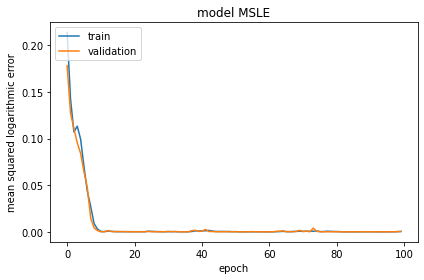

[INFO] predicting...
Final score (MSE): 0.001625885544254723
Final score (MAE): 0.033796536293321085
Final score (RMSE): 0.040322271070150836


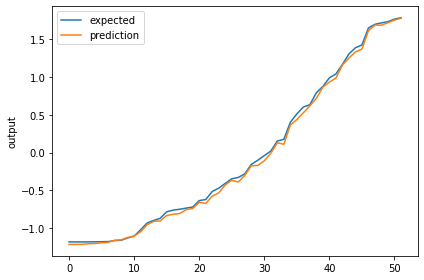

In [3]:
# Here, I learn one specific level of R_ci spanning all temperatures
x=dataset[:,0:1]  # Temperatures
y=dataset[:,9:10]  # Rci (relaxation source terms)

# Here, I fix the temperature and learn all levels of R_ci
#x=dataset[150,0:1]   # Temperatures
#y=dataset[150,1:50]  # Rci (relaxation source terms)

# TODO: Here, I want to learn all T and all Rci alltogether
#x=dataset[:,0:1]   # Temperatures
#y=dataset[:,1:50]  # Rci (relaxation source terms)


# 2D Plot
plt.scatter(x, y, s=0.5)
plt.title('$R_{ci}$ for $N_2/N$ and i = 10')
plt.xlabel('T [K]')
plt.ylabel('$R_{ci}$ $[J/m^3/s]$')
plt.tight_layout()
plt.savefig("relaxation_source_terms.pdf")
plt.show()

# Implementing a NN, it is beneficial to normalize the variables.
print("[INFO] StandardScaling data...")
y=np.reshape(y, (-1,1))
scaler_x = StandardScaler() #MinMaxScaler() #StandardScaler() #RobustScaler() #MaxAbsScaler()
scaler_y = StandardScaler()
print(scaler_x.fit(x))
xscale=scaler_x.transform(x)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

# The data is then split into training and test data
# Let's use 20% of original data for testing
# The random_state is just for reproducibility (see function doc)
print("[INFO] constructing training/testing split...")
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale, test_size=0.2, random_state=42)

model = Sequential()

# Usually it's a good practice to apply following formula in order to find out the total number of hidden layers needed.
#
# Nh = Ns/(α∗ (Ni + No))
#
# where
#
#    Ni = number of input neurons.
#    No = number of output neurons.
#    Ns = number of samples in training data set.
#    α = an arbitrary scaling factor usually 2-10.
#
# ... but I don't care and I take random number of layers and neurons per layer,
# then manually tune the NN.

model.add(Dense(20, input_dim=1, kernel_initializer='normal', activation='relu')) # Hidden 1
model.add(Dense(20, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(20, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(20, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
#model.add(Dense(100, kernel_initializer='normal', activation='relu'))              # Hidden 2
model.add(Dense(1, activation='linear'))                                            # Output
#opt = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.01)
opt = keras.optimizers.Adam(learning_rate=0.01)

model.summary()

keras2ascii(model)

# mse:  loss = square(y_true - y_pred)
# mae:  loss = abs(y_true - y_pred)
# mape: loss = 100 * abs(y_true - y_pred) / y_true
# msle: loss = square(log(y_true + 1.) - log(y_pred + 1.))
model.compile(loss='mse', metrics=['mse', 'mae', 'mape', 'msle'], optimizer=opt)

#monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Train model
# The validation_split set to 0.2, 80% of the training data is used to test the model, while the remaining 20% is used for testing.
#
# one epoch = one forward pass and one backward pass of all the training examples
#
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space.
#
# number of iterations = number of passes, each pass using [batch size] number of examples.
# One pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
#
# The batch size defines the number of samples that will be propagated through the network.
#
# Advantages of using a batch size < number of all samples:
#
# * It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory.
#   That's especially important if you are not able to fit the whole dataset in your machine's memory.
#
# * Typically networks train faster with mini-batches. That's because we update the weights after each propagation.
#
# Disadvantages of using a batch size < number of all samples:
#
# * The smaller the batch the less accurate the estimate of the gradient will be.

print("[INFO] training model...")
history = model.fit(X_train, y_train, epochs=100, batch_size=15, verbose=2, validation_data=(X_test, y_test), callbacks=[PlotLossesKeras()])


#loss_history = np.array(history)
#np.savetxt("loss_history.txt", loss_history, delimiter=",")

# Plot metrics
print(history.history.keys())

# "Loss"
plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MSE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MAE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model MAPE')
plt.ylabel('mean absolute percentage error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MAPE.pdf", dpi=150)
plt.show()

plt.figure()
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model MSLE')
plt.ylabel('mean squared logarithmic error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("MSLE.pdf", dpi=150)
plt.show()

# Predict
print("[INFO] predicting...")
pred = model.predict(X_test)

score = metrics.mean_squared_error(pred, y_test)
print("Final score (MSE): {}".format(score))

score = metrics.mean_absolute_error(pred, y_test)
print("Final score (MAE): {}".format(score))

# Measure RMSE error. RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Final score (RMSE): {}".format(score))

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.tight_layout()
    plt.savefig("adim_regression.pdf", dpi=150)
    plt.show()

# Plot the chart
chart_regression(pred.flatten(), y_test)

X=[6750.], Predicted=[1.4243834e+20]
X=[6800.], Predicted=[2.0800769e+20]
X=[6850.], Predicted=[3.0062713e+20]
X=[6900.], Predicted=[4.292215e+20]
X=[6950.], Predicted=[5.8993295e+20]
X=[7000.], Predicted=[7.537189e+20]
X=[7050.], Predicted=[9.1685245e+20]
X=[7100.], Predicted=[1.0448626e+21]
X=[7150.], Predicted=[1.1468539e+21]
X=[7200.], Predicted=[1.216049e+21]
X=[7300.], Predicted=[1.2864652e+21]
X=[7400.], Predicted=[1.2783969e+21]
X=[7500.], Predicted=[1.2293165e+21]
X=[7600.], Predicted=[1.15266585e+21]
X=[7700.], Predicted=[1.0721584e+21]
X=[7800.], Predicted=[9.829595e+20]
X=[7900.], Predicted=[8.930238e+20]
X=[8000.], Predicted=[8.054434e+20]
X=[8100.], Predicted=[7.174248e+20]
X=[8200.], Predicted=[6.3924375e+20]
X=[8300.], Predicted=[5.708522e+20]
X=[8400.], Predicted=[5.0297506e+20]
X=[8500.], Predicted=[4.4707874e+20]
X=[8600.], Predicted=[3.9306337e+20]
X=[8700.], Predicted=[3.4356646e+20]
X=[8800.], Predicted=[2.995862e+20]
X=[8900.], Predicted=[2.5985747e+20]
X=[9000.]

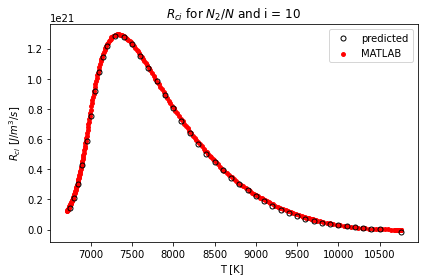

In [4]:
Xnew = np.array([[6750], [6800], [6850],[6900], [6950], 
                 [7000], [7050],[7100], [7150], [7200], [7300], [7400], [7500], [7600], [7700], [7800], [7900], 
                 [8000], [8100], [8200], [8300], [8400], [8500], [8600], [8700], [8800], [8900],
                 [9000], [9100], [9200], [9300], [9400], [9500], [9600], [9700], [9800], [9900],
                 [10000], [10100], [10200], [10300], [10400], [10500], [10757]])

Xnew = scaler_x.transform(Xnew)
ynew = model.predict(Xnew)

# Invert normalize
ynew = scaler_y.inverse_transform(ynew)
Xnew = scaler_x.inverse_transform(Xnew)
# show the inputs and predicted outputs
for i in range(len(Xnew)):
    print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))
    
print(x.min(), x.max())

plt.scatter(x[:], y[:], s=15, facecolor='red', label='MATLAB')     
plt.plot(Xnew[:], ynew[:], 'o', color='black', label='predicted', linewidth=2, markersize=5, fillstyle='none')
plt.title('$R_{ci}$ for $N_2/N$ and i = 10')
plt.ylabel('$R_{ci}$ $[J/m^3/s]$')
plt.xlabel('T [K] ')
plt.legend()
plt.tight_layout()
plt.savefig("dim_regression.pdf", dpi=150, crop='false')
plt.show()